In [73]:
%matplotlib inline

import glob
from platform import python_version
import pandas as pd
import matplotlib
import numpy as np
import pandas as pd
import sklearn
import torch
import matplotlib.pyplot as plt

In [74]:
print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("sklearn==%s" % sklearn.__version__)
print("torch==%s" % torch.__version__)
print("matplotlib==%s" % matplotlib.__version__)

python version==3.11.8
pandas==2.1.2
numpy==1.26.1
sklearn==1.3.2
torch==2.1.1+cu121
matplotlib==3.8.1


In [75]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [76]:
#load data
data = pd.read_csv("..\..\Data\Day\S&P 500 Historical Data00-20.csv")

In [77]:
#transform data
data = data.replace(",", "", regex=True)
data.Date = pd.to_datetime(data.Date)
data = data.sort_values(by=["Date"])
data.set_index('Date')
data.Price = data.Price.astype(float)
data.High = data.High.astype(float)
data.Low = data.Low.astype(float)
data.Open = data.Open.astype(float)
data["Vol."] = data["Vol."].astype(float)

In [78]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
4999,2000-01-03,1455.2,1469.2,1478.0,1438.4,NaN,-0.95%
4998,2000-01-04,1399.4,1455.2,1455.2,1397.4,NaN,-3.83%
4997,2000-01-05,1402.1,1399.4,1413.3,1377.7,NaN,0.19%
4996,2000-01-06,1403.5,1402.1,1411.9,1392.0,NaN,0.10%
4995,2000-01-07,1441.5,1403.5,1441.5,1400.5,NaN,2.71%


In [79]:
data.index = data.index[::-1]

In [80]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2000-01-03,1455.2,1469.2,1478.0,1438.4,NaN,-0.95%
1,2000-01-04,1399.4,1455.2,1455.2,1397.4,NaN,-3.83%
2,2000-01-05,1402.1,1399.4,1413.3,1377.7,NaN,0.19%
3,2000-01-06,1403.5,1402.1,1411.9,1392.0,NaN,0.10%
4,2000-01-07,1441.5,1403.5,1441.5,1400.5,NaN,2.71%


In [81]:
special_data = data[(data['Date'] > '2010-01-01') & (data['Date'] < '2015-01-01')]
special_data.index = data.index[:len(special_data)]

In [82]:
special_data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2010-01-04,1132.99,1116.56,1133.87,1116.56,NaN,1.60%
1,2010-01-05,1136.52,1132.66,1136.63,1129.66,NaN,0.31%
2,2010-01-06,1137.14,1135.71,1139.19,1133.95,NaN,0.05%
3,2010-01-07,1141.69,1136.27,1142.46,1131.32,NaN,0.40%
4,2010-01-08,1144.98,1140.52,1145.39,1136.22,NaN,0.29%


In [83]:
#change indexes
special_data.set_index('Date', inplace=True)

In [84]:
special_data = special_data.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'])

In [85]:
special_data.head()

,Price
Date,
2010-01-04,1132.99
2010-01-05,1136.52
2010-01-06,1137.14
2010-01-07,1141.69
2010-01-08,1144.98


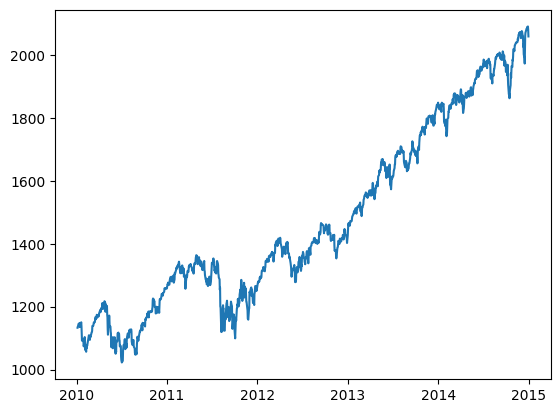

In [86]:
plt.plot(special_data)

In [87]:
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(special_data)

seq_length = 100
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.7)
val_size = 100
test_size = len(y) - train_size - val_size

dataX = Variable(torch.Tensor(np.array(x)).to(device))
dataY = Variable(torch.Tensor(np.array(y)).to(device))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])).to(device))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])).to(device))

testX = Variable(torch.Tensor(np.array(x[train_size:(len(x) - val_size)])).to(device))
testY = Variable(torch.Tensor(np.array(y[train_size:(len(y) - val_size)])).to(device))

valX = Variable(torch.Tensor(np.array(x[(len(x) - val_size):len(x)])).to(device))
valY = Variable(torch.Tensor(np.array(y[(len(x) - val_size):len(y)])).to(device))

In [88]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_dataset = TimeSeriesDataset(trainX, trainY)
test_dataset = TimeSeriesDataset(testX, testY)
val_dataset = TimeSeriesDataset(valX, valY)

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle = False)

In [89]:
import torch.nn as nn

class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(GRUNet, self).__init__()

        # set parameters
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # define layers
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # initialize hidden state
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_dim)).to(device)

        # forward propagate GRU
        out, _ = self.gru(x, h0)

        # decode hidden state of last time step
        out = self.fc(out[:, -1, :])
        return out

Epoch [1/200], Train Loss: 0.1145, Valid Loss: 0.1224
Epoch [11/200], Train Loss: 0.0099, Valid Loss: 0.0418
Epoch [21/200], Train Loss: 0.0014, Valid Loss: 0.0042
Epoch [31/200], Train Loss: 0.0010, Valid Loss: 0.0002
Epoch [41/200], Train Loss: 0.0005, Valid Loss: 0.0018
Epoch [51/200], Train Loss: 0.0002, Valid Loss: 0.0003
Epoch [61/200], Train Loss: 0.0002, Valid Loss: 0.0005
Epoch [71/200], Train Loss: 0.0002, Valid Loss: 0.0003
Epoch [81/200], Train Loss: 0.0002, Valid Loss: 0.0002
Epoch [91/200], Train Loss: 0.0002, Valid Loss: 0.0002
Epoch [101/200], Train Loss: 0.0002, Valid Loss: 0.0001
Epoch [111/200], Train Loss: 0.0002, Valid Loss: 0.0001
Epoch [121/200], Train Loss: 0.0002, Valid Loss: 0.0001
Epoch [131/200], Train Loss: 0.0002, Valid Loss: 0.0001
Epoch [141/200], Train Loss: 0.0002, Valid Loss: 0.0001
Epoch [151/200], Train Loss: 0.0002, Valid Loss: 0.0001
Epoch [161/200], Train Loss: 0.0002, Valid Loss: 0.0001
Epoch [171/200], Train Loss: 0.0002, Valid Loss: 0.0001
Epo

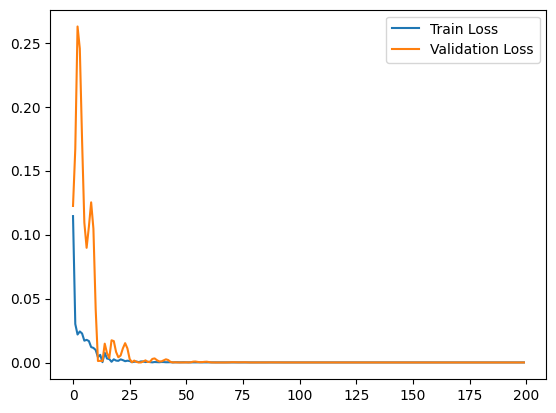

In [90]:
input_dim = 1
hidden_dim = 64
output_dim = 1
num_layers = 2
learning_rate = 0.01
num_epochs = 200

num_classes = 1

model = GRUNet(input_dim, hidden_dim, output_dim, num_layers).to(device)

# Define loss and optimizer
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr = learning_rate)

train_loss = []
valid_loss = []

for epoch in range(num_epochs):
    # set the model to train mode
    model.train()

    # forward pass
    output = model(trainX)
    loss = criterion(output, trainY)

    # backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # calculate training loss
    train_loss.append(loss.item())

    # set the model to evaluation mode
    model.eval()

    # calculate validation loss
    with torch.no_grad():
        output = model(testX)
        loss = criterion(output, testY)
        valid_loss.append(loss.item())

    # print progress
    if epoch % 10 == 0:
        print('Epoch [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'.format(
            epoch+1, num_epochs, train_loss[-1], valid_loss[-1]))

# plot train and validation loss
plt.plot(train_loss, label='Train Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.legend()
plt.show()

In [93]:
from sklearn.metrics import mean_squared_error
# Test the model
model.eval()
test_predict = model(testX)

test_predict_inv = sc.inverse_transform(test_predict.cpu().detach().numpy())
testY_inv = sc.inverse_transform(testY.cpu().detach().numpy())
print(len(test_predict_inv))
print(len(testX))

test_score = np.sqrt(mean_squared_error(testY_inv, test_predict_inv))
print("Test RMSE Score: %.2f" % test_score)

248
248
Test RMSE Score: 12.24


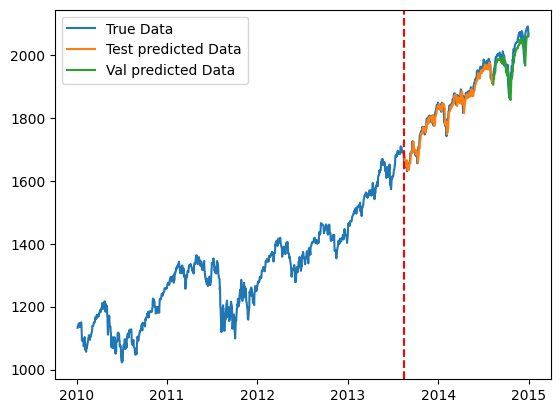

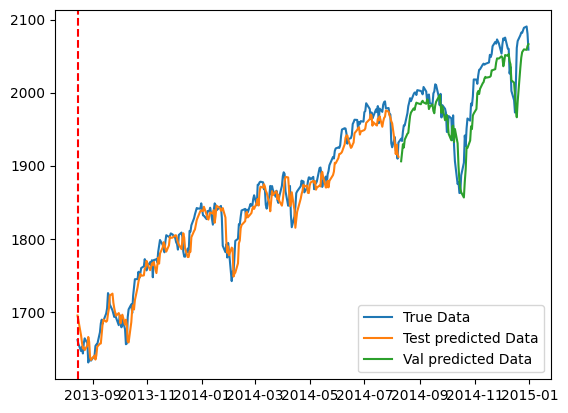

In [36]:
import matplotlib.pyplot as plt

# make predictions
predY_test = model(testX)
predY_val = model(valX)

# invert scaling for forecast
predY_test_inv = sc.inverse_transform(predY_test.cpu().detach().numpy())
predY_val_inv = sc.inverse_transform(predY_val.cpu().detach().numpy())
testY_inv = sc.inverse_transform(testY.cpu().detach().numpy())
# plot 1
plt.plot(special_data, label='True Data')
plt.plot(special_data.index[-len(predY_test_inv)- val_size: - val_size], predY_test_inv, label='Test predicted Data')
plt.plot(special_data.index[-len(predY_val_inv):], predY_val_inv, label='Val predicted Data')
plt.axvline(x=special_data.index[-len(predY_test_inv)- val_size], c='r', linestyle='--')
plt.legend()
plt.show()
# plot 2
plt.plot(special_data.index[-len(predY_test_inv)- val_size:], special_data.Price[-len(predY_test_inv)- val_size:], label='True Data')
plt.plot(special_data.index[-len(predY_test_inv)- val_size: - val_size], predY_test_inv, label='Test predicted Data')
plt.plot(special_data.index[-len(predY_val_inv):], predY_val_inv, label='Val predicted Data')
plt.axvline(x=special_data.index[-len(predY_test_inv)- val_size], c='r', linestyle='--')
plt.legend()
plt.show()

## Инициализация

In [49]:
%matplotlib inline
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

import glob
from platform import python_version
import pandas as pd
import matplotlib
import numpy as np
import sklearn
import torch
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [51]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(GRUNet, self).__init__()

        # set parameters
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # define layers
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # initialize hidden state
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_dim)).to(device)

        # forward propagate GRU
        out, _ = self.gru(x, h0)

        # decode hidden state of last time step
        out = self.fc(out[:, -1, :])
        return out

## Чтение входных данных

### Загрузка данных

In [166]:
data = pd.read_csv("..\..\Data\Day\\jpe_Linear.csv", index_col = 0)

### Трансформация данных

In [167]:
def data_transformer(data):
    if 'Close' in data.columns:
        data = data.replace(",", "", regex=True)
        data.Date = pd.to_datetime(data.Date)
        data = data.sort_values(by=["Date"])
        data.set_index('Date')
        data.Close = data.Close.astype(float)
        data.High = data.High.astype(float)
        data.Low = data.Low.astype(float)
        data.Open = data.Open.astype(float)
        data["Vol"] = data["Vol"].astype(float)
    else:
        data = data.replace(",", "", regex = True)
        data.Date = pd.to_datetime(data.Date)
        data = data.sort_values(by=["Date"])
        data.set_index('Date')
        data.Price = data.Price.astype(float)
        data.High = data.High.astype(float)
        data.Low = data.Low.astype(float)
        data.Open = data.Open.astype(float)
        data["Vol."] = data["Vol."].astype(float)

In [168]:
data_transformer(data)

In [169]:
data.head()

,Date,Open,High,Low,Close,Vol
0,2010-01-04,42.885,42.89,42.85,42.85,312873.0
1,2010-01-05,43.690,43.70,43.66,43.67,342934.0
2,2010-01-06,43.900,43.92,43.90,43.91,135930.0
3,2010-01-07,44.770,44.82,44.77,44.81,307549.0
4,2010-01-08,44.600,44.67,44.59,44.67,219077.0


In [170]:
data.index = data.index[::-1]

In [171]:
data.head()

,Date,Open,High,Low,Close,Vol
1457,2010-01-04,42.885,42.89,42.85,42.85,312873.0
1456,2010-01-05,43.690,43.70,43.66,43.67,342934.0
1455,2010-01-06,43.900,43.92,43.90,43.91,135930.0
1454,2010-01-07,44.770,44.82,44.77,44.81,307549.0
1453,2010-01-08,44.600,44.67,44.59,44.67,219077.0


In [172]:
special_data = data[(data['Date'] > '2010-01-01') & (data['Date'] < '2015-01-01')]
special_data.index = data.index[:len(special_data)]

In [173]:
special_data.head()

,Date,Open,High,Low,Close,Vol
1457,2010-01-04,42.885,42.89,42.85,42.85,312873.0
1456,2010-01-05,43.690,43.70,43.66,43.67,342934.0
1455,2010-01-06,43.900,43.92,43.90,43.91,135930.0
1454,2010-01-07,44.770,44.82,44.77,44.81,307549.0
1453,2010-01-08,44.600,44.67,44.59,44.67,219077.0


In [174]:
#change indexes
special_data.set_index('Date', inplace=True)

In [175]:
special_data = special_data.drop(columns=['Open', 'High', 'Low'])
if 'Change %' in special_data.columns:
    special_data = special_data.drop(columns=['Change %'])
if 'Vol' in special_data.columns:
    special_data = special_data.drop(columns=['Vol'])
if 'Vol.' in special_data.columns:
    special_data = special_data.drop(columns=['Vol.'])
if 'Close' in special_data.columns:
    special_data.rename(columns = {'Close':'Price'}, inplace = True)

In [176]:
special_data.head()

,Price
Date,
2010-01-04,42.85
2010-01-05,43.67
2010-01-06,43.91
2010-01-07,44.81
2010-01-08,44.67


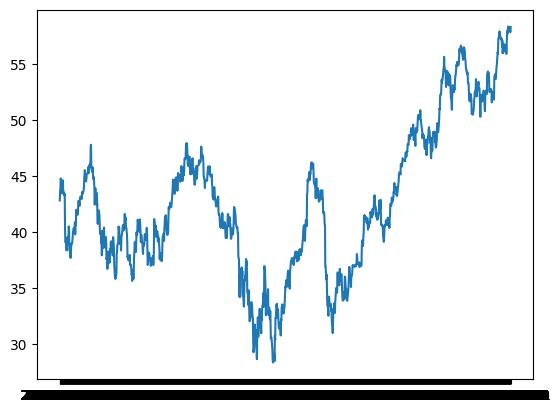

In [177]:
plt.plot(special_data)

## Начало расчёта

### Создаём наш объект для хранения результатов

In [178]:
forecasts = pd.DataFrame(columns = \
                         ['begin_date', 
                          'end_date', 
                          'window_size', 
                          'forecast_days', 
                          'forecast_precision'])

### Задаём все параметры симуляции и моделей

In [179]:
# Размер окна и размер прогноза
window_size = 200
forecast_days = 90
# гиперпараметры
num_epochs = 400
learning_rate = 0.001
input_size = 1
hidden_size = 64 # need to find correct value; 40 small, 64 norm, 100 a lot
num_layers = 1
num_classes = 1
output_size = 1

### Обучаем модель, прогнозируем и сохраняем результат

In [180]:
import sys

train_size = int(0.8 * window_size)
val_size = forecast_days
test_size = int(0.2 * window_size)
sim_len = len(special_data) - window_size - forecast_days - val_size
prev_percent = 0
# начинаем симуляцию
for i in range(0, sim_len):
    percent = int(100 * (i + 1) / sim_len)

    if percent > prev_percent:
        prev_percent = percent
        sys.stdout.write(f"\rПрогресс: {percent}%")
        sys.stdout.flush()
    
    seq_length = 10

    window = special_data[i:i + window_size + forecast_days + 1 + seq_length]
    actual_values = special_data['Price'][i + window_size:i + window_size + forecast_days]
    # Переводим наши данные в тензора на наш расчётный девайс
    sc = MinMaxScaler()
    training_data = sc.fit_transform(window)

    x, y = sliding_windows(training_data, seq_length)


    dataX = Variable(torch.Tensor(np.array(x)).to(device))
    dataY = Variable(torch.Tensor(np.array(y)).to(device))

    trainX = Variable(torch.Tensor(np.array(x[0:train_size])).to(device))
    trainY = Variable(torch.Tensor(np.array(y[0:train_size])).to(device))

    testX = Variable(torch.Tensor(np.array(x[train_size:train_size + test_size])).to(device))
    testY = Variable(torch.Tensor(np.array(y[train_size:train_size + test_size])).to(device))

    valX = Variable(torch.Tensor(np.array(x[train_size + test_size:train_size + test_size + val_size])).to(device))
    valY = Variable(torch.Tensor(np.array(y[train_size + test_size:train_size + test_size + val_size])).to(device))  
    
    #  Создаём классы для наших датасетов
    train_dataset = TimeSeriesDataset(trainX, trainY)
    test_dataset = TimeSeriesDataset(testX, testY)
    val_dataset = TimeSeriesDataset(valX, valY)

    train_loader = DataLoader(train_dataset, batch_size = 10, shuffle = False)
    test_loader = DataLoader(test_dataset, batch_size = 10, shuffle = False)
    val_loader = DataLoader(val_dataset, batch_size = 10, shuffle = False)

    # Создаём модель 
    model = GRUNet(input_size, hidden_size, num_layers, output_size).to(device)
    
    # Define loss and optimizer
    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    #optimizer = torch.optim.SGD(lstm.parameters(), lr = learning_rate)

    train_loss = []
    valid_loss = []
    for epoch in range(num_epochs):
        # set the model to train mode
        model.train()

        # forward pass
        output = model(trainX)
        loss = criterion(output, trainY)

        # backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # calculate training loss
        train_loss.append(loss.item())

        # set the model to evaluation mode
        model.eval()

        # calculate validation loss
        with torch.no_grad():
            output = model(testX)
            loss = criterion(output, testY)
            valid_loss.append(loss.item())

    predY_val = model(valX)
    predY_val_inv = sc.inverse_transform(predY_val.cpu().detach().numpy()).ravel()
    percentage_error = ((predY_val_inv - actual_values) / actual_values) * 100
    result = {
                'begin_date': window.index[0],
                'end_date': window.index[-(forecast_days + val_size + 1)],
                'window_size': window_size,
                'forecast_days': forecast_days,
                'forecast_precision': np.mean(np.abs(percentage_error))
            }
    forecasts = pd.concat([forecasts, pd.DataFrame([result])], ignore_index = True)


C:\Users\Skiv2\AppData\Local\Temp\ipykernel_2376\2743976693.py:94: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  forecasts = pd.concat([forecasts, pd.DataFrame([result])], ignore_index = True)


Прогресс: 100%

In [181]:
# Преобразуйте столбец 'forecast_precision' к типу данных float
forecasts['forecast_precision'] = pd.to_numeric(forecasts['forecast_precision'], errors='coerce')

# Получите 10 строк с наименьшими значениями в столбце 'forecast_precision'
top_10_rows = forecasts.nsmallest(10, 'forecast_precision', 'all')

In [182]:
top_10_rows

,begin_date,end_date,window_size,forecast_days,forecast_precision
872,2012-05-25,2012-09-22,200,90,1.357275
873,2012-05-26,2012-09-23,200,90,1.386360
870,2012-05-23,2012-09-20,200,90,1.429340
875,2012-05-28,2012-09-25,200,90,1.440263
876,2012-05-29,2012-09-26,200,90,1.481689
871,2012-05-24,2012-09-21,200,90,1.489048
874,2012-05-27,2012-09-24,200,90,1.490634
878,2012-05-31,2012-09-28,200,90,1.500532
901,2012-06-23,2012-10-21,200,90,1.505693
842,2012-04-25,2012-08-23,200,90,1.509424


In [183]:
# Сортировка по forecast_precision и получение первых 10 строк
sorted_result = forecasts.sort_values(by='forecast_precision').head(10)

# Вывод результата
print(sorted_result)

     begin_date    end_date window_size forecast_days  forecast_precision
872  2012-05-25  2012-09-22         200            90            1.357275
873  2012-05-26  2012-09-23         200            90            1.386360
870  2012-05-23  2012-09-20         200            90            1.429340
875  2012-05-28  2012-09-25         200            90            1.440263
876  2012-05-29  2012-09-26         200            90            1.481689
871  2012-05-24  2012-09-21         200            90            1.489048
874  2012-05-27  2012-09-24         200            90            1.490634
878  2012-05-31  2012-09-28         200            90            1.500532
901  2012-06-23  2012-10-21         200            90            1.505693
842  2012-04-25  2012-08-23         200            90            1.509424


In [184]:
result_df = forecasts.groupby(['forecast_days'])['forecast_precision'].mean().reset_index()

In [185]:
print(result_df)

   forecast_days  forecast_precision
0             90            3.216144


In [186]:
forecasts.to_csv('gru_jpe.csv')